In [24]:
import numpy as np 
from sklearn.cluster import KMeans 
import itertools
import pulp

In [25]:
np.random.seed(42)

In [26]:
def group_matrices(list_matrix, k):
    """
    Args:
        list_matrix : list of matrices 
        k (int): number of clusters 
    """
    if not isinstance(k, int):
        raise ValueError("k must be an integer")
    
    num = list_matrix.shape[0]
    # a sample as a matrix, e.g 7x7 => we have 49 features 
    data = list_matrix.reshape(num, -1)
    
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data)
    labels = model.labels_
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(labels):
        clusters[label].append(list_matrix[idx])
    
    groups = [np.array(group) for group in clusters]
    
    return groups

In [27]:
n = 100
matrices = np.random.random((n, 7, 7))
    
k = 10  # number of clusters
groups = group_matrices(matrices, k)

for i, group in enumerate(groups):
        print(f"Cluster {i}: shape {group.shape}")

Cluster 0: shape (1, 7, 7)
Cluster 1: shape (14, 7, 7)
Cluster 2: shape (11, 7, 7)
Cluster 3: shape (10, 7, 7)
Cluster 4: shape (13, 7, 7)
Cluster 5: shape (10, 7, 7)
Cluster 6: shape (15, 7, 7)
Cluster 7: shape (6, 7, 7)
Cluster 8: shape (9, 7, 7)
Cluster 9: shape (11, 7, 7)


In [28]:
def characteristic_func(coalition):
    if not coalition:
        return 0.0
    # each group have (n matrices, matrix) ==> concat [matrices] 
    all_matrices = np.concatenate([groups[i] for i in coalition], axis=0)
    
    return np.mean(np.square(all_matrices))

In [29]:
def compute_nucleolus(num_players, characteristic_func):
    
    players = list(range(num_players))
    
    # Set up the linear programming problem
    prob = pulp.LpProblem("Nucleolus", pulp.LpMinimize)
    
    # Decision variables: one allocation x_i per player and epsilon
    x = {i: pulp.LpVariable(f"x_{i}", lowBound=None, cat='Continuous') for i in players}
    epsilon = pulp.LpVariable("epsilon", lowBound=None, cat='Continuous')
    
    
    # Objective: minimize epsilon (the worst excess)
    prob += epsilon, "Minimize_epsilon"
    
    # Efficiency constraint: total allocation equals the value of the grand coalition
    grand_coalition = tuple(players)
    prob += pulp.lpSum([x[i] for i in players]) == characteristic_func(grand_coalition), "Efficiency"
    
    # For every proper coalition (nonempty and not the grand coalition),
    # ensure that the allocated sum is at least v(S) - epsilon.
    for r in range(1, num_players):
        for S in itertools.combinations(players, r):
            S = tuple(sorted(S))
            prob += pulp.lpSum([x[i] for i in S]) >= characteristic_func(S) - epsilon, f"Coalition_{S}"
    
    # Solve the LP
    prob.solve()
    
    allocation = [pulp.value(x[i]) for i in players]
    eps_val = pulp.value(epsilon)
    
    return allocation, eps_val

In [30]:
num_players = len(groups)
allocation, eps_val = compute_nucleolus(num_players, characteristic_func)

print("Nucleolus allocation (approximate):", allocation)
print("Worst excess (epsilon):", eps_val)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/infres/xnguyen-24/xuanhoang_Environement/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/eb75bf53807243e4b6f0983cd3a56917-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/eb75bf53807243e4b6f0983cd3a56917-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1028 COLUMNS
At line 7172 RHS
At line 8196 BOUNDS
At line 8208 ENDATA
Problem MODEL has 1023 rows, 11 columns and 6142 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1023 (0) rows, 11 (0) columns and 6142 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0 ( 0%) - largest zero change 0
0  Obj 0 Primal inf 338.24676 (1023) Dual inf 0.0099999 (1) w.o. free dual inf (0)
10  Obj 0.36960866
10  Obj -2.5e+10 Primal inf 2.555e+13 (766) Dual inf 9.0422e+15 (2) w.o. free dual inf (1)
11  Obj 0.36

In [31]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

In [32]:
def compute_group_representative(group):
    mean_matrix = np.mean(group, axis=0)  
    return mean_matrix.flatten()  #eg 7*7 ==> 49        

In [33]:
def compute_correlation_distance(vec1, vec2):
    
    if np.std(vec1) == 0 or np.std(vec2) == 0:
        return 1.0
    corr = np.corrcoef(vec1, vec2)[0, 1]
    return 1 - corr

In [34]:
def compute_custom_distance_matrix(groups, nucleolus_allocation, alpha):
    """
    Distance between group i and j:
      d = alpha * |nucleolus_i - nucleolus_j| + (1 - alpha) * (1 - corr(rep_i, rep_j))
    """
    n = len(groups)

    # Compute representative vectors for each group.
    representatives = [compute_group_representative(group) for group in groups]
    
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            nuc_diff = abs(nucleolus_allocation[i] - nucleolus_allocation[j])
            corr_dist = compute_correlation_distance(representatives[i], representatives[j])
            distance = alpha * nuc_diff + (1 - alpha) * corr_dist
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    return dist_matrix


In [35]:
def hierarchical_clustering(groups, nucleolus_allocation, alpha, n_clusters=3):
    """
    Perform hierarchical clustering on the groups using the custom distance metric.
    
    Returns:
        cluster_labels: An array with cluster labels for each group.
        linkage_matrix: The hierarchical clustering linkage matrix.
    """
    # Compute the full pairwise distance matrix.
    dist_matrix = compute_custom_distance_matrix(groups, nucleolus_allocation, alpha)
    
    # Convert the square distance matrix to condensed form (required by linkage)
    condensed_dist = squareform(dist_matrix)
    
    # Compute the hierarchical clustering using an average linkage.
    linkage_matrix = sch.linkage(condensed_dist, method='average')
    
    # Assign each group a cluster label such that there are n_clusters clusters.
    cluster_labels = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    return cluster_labels, linkage_matrix

In [39]:
alpha = 0.5  
nucleolus_allocation = compute_nucleolus(num_players, characteristic_func)[0]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/infres/xnguyen-24/xuanhoang_Environement/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/4827116cd9544165952767592f625da5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/4827116cd9544165952767592f625da5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1028 COLUMNS
At line 7172 RHS
At line 8196 BOUNDS
At line 8208 ENDATA
Problem MODEL has 1023 rows, 11 columns and 6142 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1023 (0) rows, 11 (0) columns and 6142 (0) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0 ( 0%) - largest zero change 0
0  Obj 0 Primal inf 338.24676 (1023) Dual inf 0.0099999 (1) w.o. free dual inf (0)
10  Obj 0.36960866
10  Obj -2.5e+10 Primal inf 2.555e+13 (766) Dual inf 9.0422e+15 (2) w.o. free dual inf (1)
11  Obj 0.36

In [41]:
cluster_labels, linkage_matrix = hierarchical_clustering(groups, nucleolus_allocation, alpha, n_clusters=3)

In [42]:
print("Cluster labels for the 10 groups:", cluster_labels)

Cluster labels for the 10 groups: [2 3 3 1 2 1 1 3 1 3]


In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

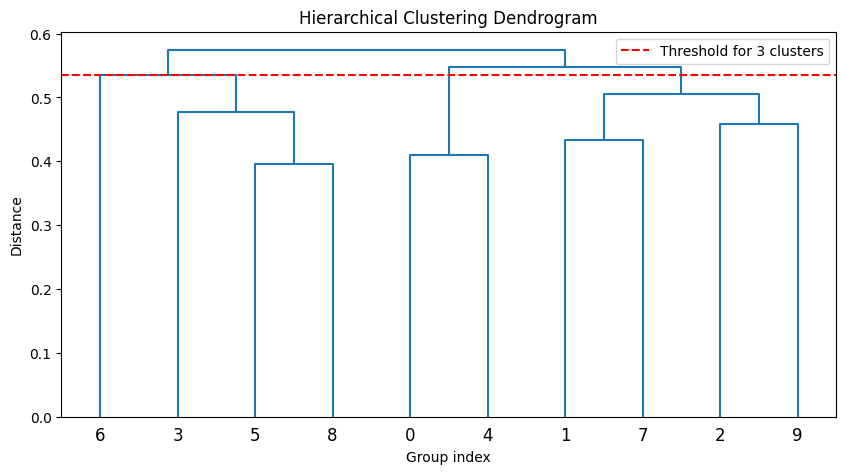

In [46]:
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Group index")
plt.ylabel("Distance")
plt.axhline(y=linkage_matrix[-3, 2], color='r', linestyle='--', label="Threshold for 3 clusters")
plt.legend()
plt.show()

In [48]:
clusters = {}
for idx, label in enumerate(cluster_labels):
    clusters.setdefault(label, []).append(idx)


In [49]:
# Display the extracted clusters.
for label, group_indices in clusters.items():
    print(f"Cluster {label}: Groups {group_indices}")

Cluster 2: Groups [0, 4]
Cluster 3: Groups [1, 2, 7, 9]
Cluster 1: Groups [3, 5, 6, 8]
